<a href="https://colab.research.google.com/github/dailyLi/Twitter_US_Airline/blob/main/twitter_airline_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Sentiment Analysis with Twitter Airline Data Set

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/Twitter_airline/Tweets.csv')

In [4]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


## Preprocessing
- Remove duplicates
- Remove & convert words in "text"
- Encode labels into numbers
- Select relevant columns for modeling

In [5]:
data.drop_duplicates(keep='first',inplace=True)

In [6]:
data['text']=data['text'].str.replace('@VirginAmerica','')
data['text']=data['text'].str.replace('@united','')
data['text']=data['text'].str.replace('@SouthwestAir','')
data['text']=data['text'].str.replace('@JetBlue','')
data['text']=data['text'].str.replace('@AmericanAir','')
data['text']=data['text'].str.replace('@USAirways','')

In [7]:
data['text']=data['text'].str.lower()

In [8]:
data['airline_sentiment']=data['airline_sentiment'].str.replace('neutral','positive')
data['airline_sentiment'].replace(to_replace='positive', value=0, inplace=True)
data['airline_sentiment'].replace(to_replace='negative', value=1, inplace=True)

Take a brief look at how many words in each review by counting spaces in the text.

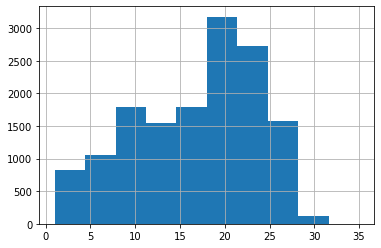

In [9]:
data["word_count"] = data["text"].str.split().str.len()
data["word_count"].hist()

## Task 1: classification for polarity

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["airline_sentiment"], test_size=0.2)
X_train

2154      your app says flight ua936 to #zrh departed 2...
5262      i actually could use a slight tweak to my ret...
5681      what does relay concerns really mean &amp; ho...
9393      delays due to refueling are out of your contr...
737      @lindaswc :  we don't like to hear you had a p...
                               ...                        
4862      want go from new orleans houston see my dad a...
11582     of course never again tho . thanks for tweeti...
11862     thanks for the reply, hoping everything is cl...
8260      can you give me an update on flight 1684 mco-...
5154                 you are the worst airline. congrats!!
Name: text, Length: 11683, dtype: object

Tokenize the text in training and testing data: choose the 20,000 most common words and set vector size as 35.

In [11]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=35)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=35)

### Build model and add layers:

In [13]:
vector_size = 200
model = tf.keras.Sequential([
                    tf.keras.layers.Embedding(max_vocab, vector_size, input_length = 35),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 200)           4000000   
                                                                 
 flatten (Flatten)           (None, 7000)              0         
                                                                 
 dense (Dense)               (None, 1)                 7001      
                                                                 
Total params: 4,007,001
Trainable params: 4,007,001
Non-trainable params: 0
_________________________________________________________________


### Train model

Since the data set contains 11,683 rows, so we run 6 epochs maximum, with batch size of 100, and use early stop that automatically stops training when a monitored metric "val_loss" has stopped improving. 

In [15]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train, epochs=6, validation_split=0.2, batch_size=60, shuffle=True)

Epoch 1/6
156/156 [==============================] - 16s 88ms/step - loss: 0.6458 - recall: 0.9748 - val_loss: 0.6139 - val_recall: 0.9155
Epoch 2/6
156/156 [==============================] - 12s 80ms/step - loss: 0.5867 - recall: 0.8812 - val_loss: 0.5807 - val_recall: 0.8801
Epoch 3/6
156/156 [==============================] - 8s 51ms/step - loss: 0.5591 - recall: 0.8685 - val_loss: 0.5613 - val_recall: 0.8649
Epoch 4/6
156/156 [==============================] - 8s 51ms/step - loss: 0.5338 - recall: 0.8682 - val_loss: 0.5392 - val_recall: 0.8649
Epoch 5/6
156/156 [==============================] - 8s 49ms/step - loss: 0.5020 - recall: 0.8841 - val_loss: 0.5120 - val_recall: 0.8683
Epoch 6/6
156/156 [==============================] - 8s 49ms/step - loss: 0.4644 - recall: 0.8967 - val_loss: 0.4821 - val_recall: 0.8926


In [16]:
history.history

{'loss': [0.6458144187927246,
  0.5867382287979126,
  0.5590563416481018,
  0.5337917804718018,
  0.5019859671592712,
  0.4644196629524231],
 'recall': [0.9747586250305176,
  0.88124680519104,
  0.868541419506073,
  0.8682026267051697,
  0.8841267228126526,
  0.896662712097168],
 'val_loss': [0.6138875484466553,
  0.5806747078895569,
  0.5612727403640747,
  0.5392009615898132,
  0.5120151042938232,
  0.48214200139045715],
 'val_recall': [0.9154539108276367,
  0.8801108598709106,
  0.8648648858070374,
  0.8648648858070374,
  0.8683298826217651,
  0.8925849199295044]}

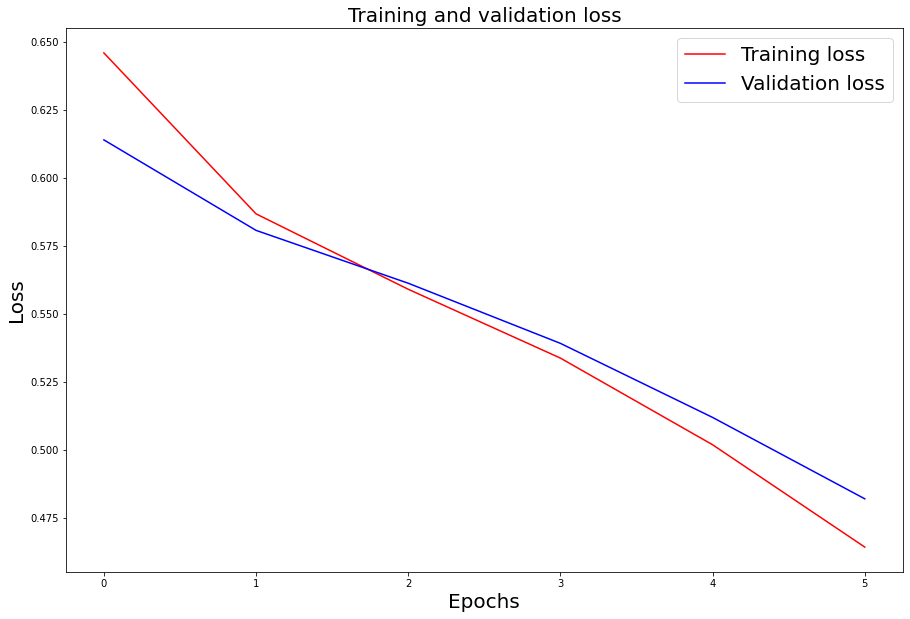

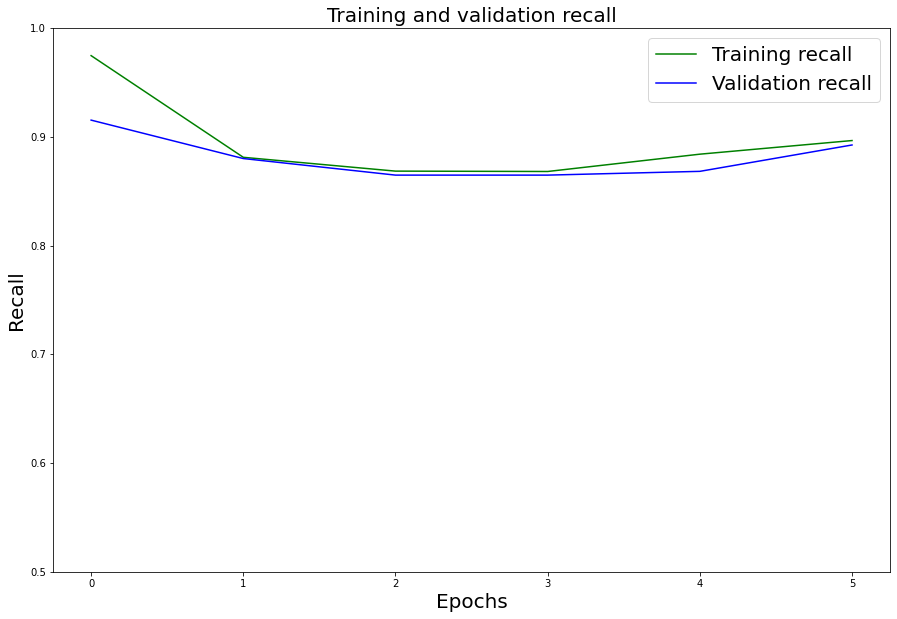

In [17]:
history_dict = history.history

recall = history_dict['recall']
val_recall = history_dict['val_recall']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs, recall, 'g', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Recall', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

### Evaluation

In [18]:
model.evaluate(X_test, y_test)

92/92 [==============================] - 0s 3ms/step - loss: 0.4832 - recall: 0.8869


[0.483242005109787, 0.8869277238845825]

In [19]:
pred = model.predict(X_test)

predictions = []

for i in pred:
    if i >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

print('Accuracy on testing set:', accuracy_score(predictions, y_test))
print('Precision on testing set:', precision_score(predictions, y_test))
print('Recall on testing set:', recall_score(predictions, y_test))

Accuracy on testing set: 0.7699418007531668
Precision on testing set: 0.8869277440706013
Recall on testing set: 0.7749397590361445


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

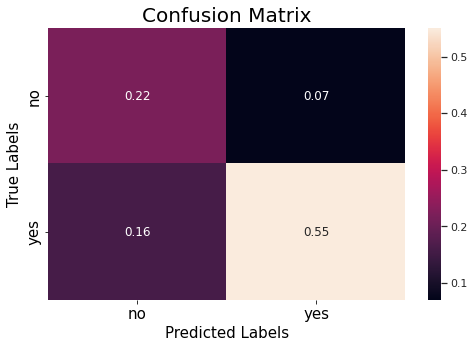

In [20]:
matrix = confusion_matrix(predictions, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["no","yes"], size=15)
ax.yaxis.set_ticklabels(["no","yes"], size=15)